### 定义模型

定义一个三层的全连接网络（FCN），也叫多层感知机（MLP）。

In [7]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, action_dim) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 定义经验回放

经验回放主要有两个功能，一是存储样本(push)，二是随时采样样本(sample)。

In [8]:
from collections import deque
import random

class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 定义策略


智能体主要负责与环境交互并更新策略(模型参数)，因此首先需要定义sample_action和predict_action两个函数，前者用于训练时的采样动作，一般会采取$\varepsilon-\text{greedy}$策略来提高探索能力，后者一般用于测试算法时的预测动作。其次需要定义update函数，这个函数主要用来从经验回放中采样样本，然后更新模型参数。

注意：
* 每个张量的维度要对应上，否则可能会报错或者不收敛

In [9]:
import random
import torch
import torch.optim as optim
import math
import numpy as np
class Policy:
    def __init__(self,cfg):
        self.target_update = cfg.target_update
        self.action_dim = cfg.action_dim  
        self.device = torch.device(cfg.device) 
        self.gamma = cfg.gamma # 奖励的折扣因子
        # e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end =cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.memory = ReplayBuffer(cfg.memory_capacity)
        # 当前网络和目标网络
        self.policy_net = MLP(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.hidden_dim).to(self.device)
        self.target_net = MLP(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.hidden_dim).to(self.device)
        # 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # 优化器
        self.update_cnt = 0 # 用于延迟更新目标网络的计数
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        else:
            action = random.randrange(self.action_dim)
        return action
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()：
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的呀恶女本
        states, actions, rewards, next_states, dones = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        states = torch.tensor(np.array(states), device=self.device, dtype=torch.float) # [batch_size, state_dim]
        actions = torch.tensor(actions, device=self.device).unsqueeze(1)  #  [batch_size, 1]
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float).unsqueeze(1)   # [batch_size, 1]
        next_states = torch.tensor(np.array(next_states), device=self.device, dtype=torch.float) # [batch_size, state_dim]
        dones = torch.tensor(np.float32(dones), device=self.device).unsqueeze(1)  # [batch_size,1]
        # 计算当前状态(s_t,a)对应的Q值
        q_values = self.policy_net(states).gather(dim=1, index=actions) 
        # 计算下一时刻的状态(s_t_,a)对应的Q值，注意需要detach()，因为不需要计算梯度
        next_q_values_max = self.target_net(next_states).max(1)[0].detach().unsqueeze(1)
        # 计算期望的Q值，对于终止状态，此时dones[0]=1, 对应的expected_q_value等于reward
        expected_q_values = rewards + self.gamma * next_q_values_max * (1-dones) # [batch_size, 1]
         # 计算均方根损失
        loss = nn.MSELoss()(q_values, expected_q_values) 
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        self.update_cnt += 1
        # 每隔一定步数更新目标网络的参数
        if self.update_cnt % self.target_update == 0:
            for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
                target_param.data.copy_(param.data)

### 定义训练

In [10]:

import gymnasium as gym

def train(cfg):
    ''' 训练
    '''
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.n)
    policy = Policy(cfg)
    rewards = []  # 记录所有回合的奖励
    frames = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = policy.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward, next_state, terminated))  # 保存transition
            state = next_state  # 更新下一个状态
            policy.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{policy.epsilon:.3f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}


## 4、设置参数

In [11]:
class Config:
    def __init__(self) -> None:
        self.algo_name = 'DQN' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.mode = 'train'
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.train_eps = 100 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.95 # 折扣因子
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500 # e-greedy策略中epsilon的衰减率
        self.memory_capacity = 100000 # 经验回放池的容量
        self.hidden_dim = 256 # 神经网络的隐藏层维度
        self.batch_size = 64 # 批次大小
        self.target_update = 100 # 目标网络的更新频率
        self.lr = 0.0001 # 学习率
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda'
        



## 5、开始训练

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	        DQN         	   <class 'str'>    
       env_id       	    CartPole-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
     train_eps      	        100         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
     max_steps      	        200         	   <class 'int'>    
       gamma        	        0.95        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
  memory_capacity   	       100000       	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	        100      

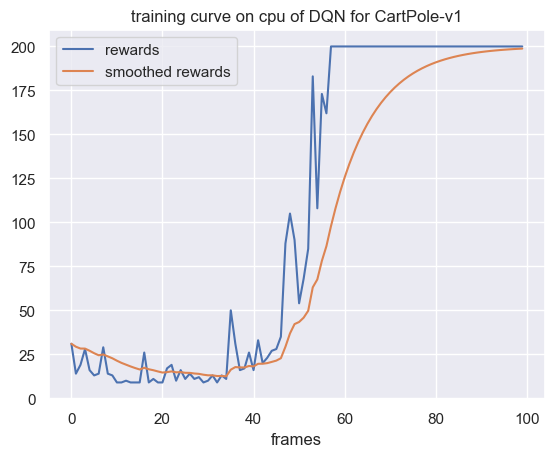

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

# 获取参数
cfg = Config() 
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])

